In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [86]:
six_hours = 3600*6*1000
four_hours = 3600*4*1000
eight_hours = 3600*8*1000
twelve_hours = 2*six_hours

In [73]:
_src = 'CERN-PROD*'
_dst = 'BNL-OSG*'

In [74]:
body_epochs="""{
  "query": {
    "filtered": {
      "query": {
        "query_string": {
          "query": "event_type:transfer-done AND payload.src-rse:%s AND payload.dst-rse:%s",
          "analyze_wildcard": true,
          "lowercase_expanded_terms": false}},
      "filter": {
        "bool": {
          "must": [{
              "range": {
                "@timestamp": {
                  "gte": %s,
                  "lte": %s,
                  "format": "epoch_millis"}}}]}}}},
  "_source": [
    "payload.file-size",
    "payload.transferred_at",
    "payload.duration"
  ],
  "fields": [
    "_source"
  ]}
"""

In [75]:
import elasticsearch
from elasticsearch import Elasticsearch, helpers
es = Elasticsearch([{'host': 'atlas-kibana.mwt2.org',
                     'port': 9200}])

In [109]:
# current_time - epochs in milliseconds

import time, math

current_time = int(ceil(time.time() * 1000))

In [110]:
from datetime import datetime
def load_chunk(src, dst, start_time, end_time):
    data = []
    scanner = helpers.scan(client=es, query=body_epochs%(src, dst, start_time, end_time), scroll='1m', index="rucio-events*", timeout="1m")
    for hit in scanner:
        data.append((hit['_source']['payload']['file-size']/1000))
    data = np.asarray(data)
    return data

In [112]:
def load_data(src, dst, number_of_pieces, piece_length):
    data = {}
    if es.ping():
        for i in range(1, number_of_pieces):
            for j in range (0, 10):
                try:
                    chunk = load_chunk(src, dst, current_time - i*piece_length, current_time - (i-1)*piece_length)
                    data[current_time - (i-1)*piece_length] = chunk
                    break
                except ConnectionTimeout:
                    if j == 10:
                        print("Can't load data after 10 tryouts")
                    continue
    else:
        print("Can't connect ElasticSearch cluster")
    return data

In [88]:
import numpy as np

import time
import datetime
from datetime import timedelta

from scipy.signal import argrelextrema

def get_clusters(data, hist_bins=10):
    clusters = {}
    for key in data.keys():
        r = []
        #hist_bins (10 by defauls as histogram's)
        a, b = np.histogram(data[key], bins = hist_bins)
        #local extremums
        maxm = argrelextrema(a, np.greater)  
        minm = argrelextrema(a, np.less)
        for j in range(0, len(minm[0])):
            r.append([])
            if minm[0][j] == minm[0][0]:
                for d in data[key]:
                    if d < b[minm[0][j]]:
                        r[j].append(d)
            else:
                for d in data[key]:
                    if d < b[minm[0][j]] and d > b[minm[0][j-1]]:
                        r[j].append(d)
        clusters[key] = r
    #code below is used for preparing data for plots: boxplots' positions, labels, etc.
    positions = {}
    keys_list = list(sorted(clusters.keys()))
    for i in range(0, len(keys_list)):
        pos = []
        for cluster in clusters[keys_list[i]]:
            pos.append(i)
        positions[keys_list[i]] = pos
    d = []
    p = []
    for key in sorted(clusters.keys()):
        for c in clusters[key]:
            d.append(c)
        for pos in positions[key]:
            p.append(pos)
    labels = []
    for key in sorted(clusters.keys()):
        labels.append(datetime.datetime.fromtimestamp(key / 1000))
    return clusters, d, p, labels

In [105]:
data7d = load_data(_src, _dst, 3*7, 2*four_hours)

In [106]:
clusters, d, p, labels = get_clusters(data7d, 20)

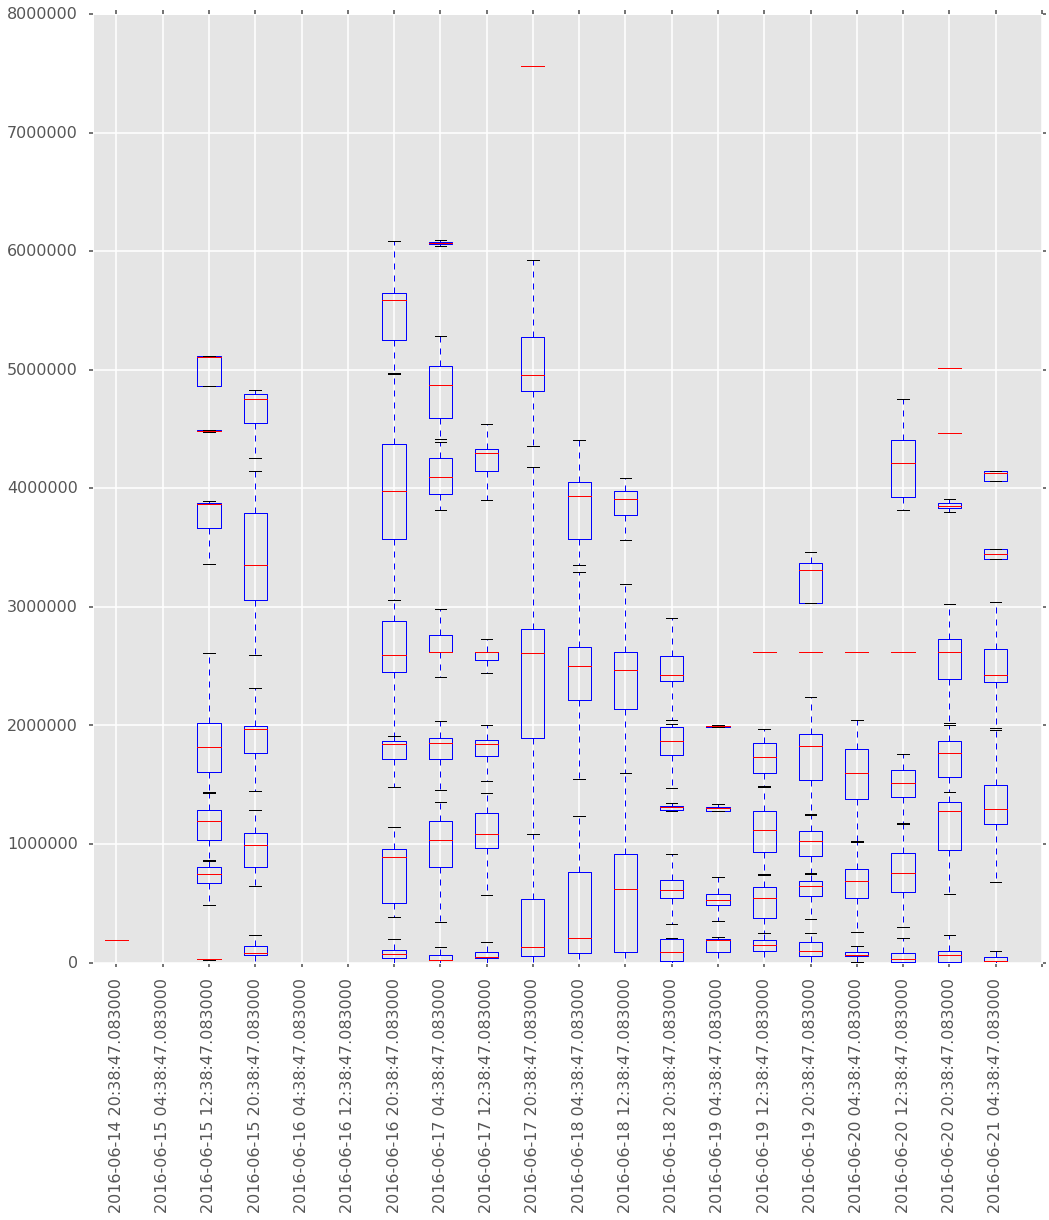

In [108]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

style.use('ggplot')
style.use('seaborn-poster')

fig = plt.figure(figsize=(17,17))
ax = fig.add_subplot(111)
a = ax.boxplot(d, positions=p)
b = plt.xticks(arange(21), labels, rotation='vertical')